# Iniciando PySpark

### Realiza instalação do pyspark

In [3]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 53 kB/s 
     |████████████████████████████████| 199 kB 54.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=f0e2fc62380eb6c3d6a1e032f42cc6bd4593ce3d687520a73d31e5ebe38d97ba
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


### Abrindo a sessão spark

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
.builder \
.appName("Project_Spark") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()



### Imports

In [74]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as f
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from pyspark.sql.window import Window
import pandas as pd
import numpy as np

# melhor visualização do dataframe
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# # Session builder
# spark = SparkSession.builder.appName('sparkdf').getOrCreate()

# Obtendo dataframe

### Importando csv

In [6]:
caminho_local = "sample_data"
nome_arq = "owid-covid-data.csv"

In [7]:
df = spark.read.format('csv').\
options(header='true', \
inferschema='true').\
load(f'{caminho_local}/{nome_arq}',header=True)

# Trabalhando com os dados

In [145]:
df.select('iso_code', 'continent', 'location',
          'date', 'total_cases', 'new_cases')\
          .show()

+--------+---------+-----------+-------------------+-----------+---------+
|iso_code|continent|   location|               date|total_cases|new_cases|
+--------+---------+-----------+-------------------+-----------+---------+
|     AFG|     Asia|Afghanistan|2020-02-24 00:00:00|        5.0|      5.0|
|     AFG|     Asia|Afghanistan|2020-02-25 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-02-26 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-02-27 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-02-28 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-02-29 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-03-01 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-03-02 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-03-03 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afghanistan|2020-03-04 00:00:00|        5.0|      0.0|
|     AFG|     Asia|Afgha

In [226]:
total_mundo = df.select('iso_code', 'total_cases', 'population')\
  .filter(f.col('date') == '2021-12-31')\
  .distinct()\
  .orderBy('iso_code')

total_mundo = total_mundo.withColumn('casos_por_populacao', 
                                     f.col('total_cases')/f.col('population'))\
                                     .orderBy(f.col('casos_por_populacao')\
                                              .desc())

total_mundo.show()

+--------+-----------+-----------+-------------------+
|iso_code|total_cases| population|casos_por_populacao|
+--------+-----------+-----------+-------------------+
|     AND|    23740.0|    79034.0| 0.3003770529139358|
|     MNE|   170034.0|   627859.0|0.27081558120533433|
|     GIB|     8701.0|    32670.0| 0.2663299663299663|
|     SVK|  1371082.0|  5447622.0|  0.251684496464696|
|     GEO|   934741.0|  3757980.0| 0.2487349586746071|
|     SMR|     8202.0|    33746.0|0.24305102827001718|
|     CZE|  2475729.0| 1.051075E7|0.23554256356587303|
|     SYC|    24788.0|   106470.0|0.23281675589367898|
|     SVN|   464048.0|  2119410.0|0.21895150065348376|
|     MNG|   692621.0|  3347782.0|0.20688951670090824|
|     BHR|   282062.0|  1463265.0|0.19276207658899788|
|     GBR| 1.296469E7| 6.728104E7|0.19269455406753522|
|     ABW|    20461.0|   106536.0|0.19205714500262822|
|     SRB|  1299339.0|  6871547.0|0.18908973481517335|
|     LTU|   524427.0|  2786651.0| 0.1881925651974359|
|     CYP|

In [227]:
tres_paises = total_mundo.where(f.col('iso_code').isin({'BRA','USA'}))
tres_paises = tres_paises.union(spark\
                                .createDataFrame([total_mundo.first()]))\
                          .orderBy(f.col('casos_por_populacao').asc())
tres_paises.show()

+--------+-----------+------------+-------------------+
|iso_code|total_cases|  population|casos_por_populacao|
+--------+-----------+------------+-------------------+
|     BRA|2.2291839E7|2.14326223E8|0.10400892008440796|
|     USA|5.4840479E7|3.36997624E8|0.16273253902822768|
|     AND|    23740.0|     79034.0| 0.3003770529139358|
+--------+-----------+------------+-------------------+



In [228]:
pd_tres_paises = tres_paises.toPandas()

In [229]:
pd_tres_paises['nome'] = ['Brasil', 'Estados Unidos', 'Andorra']

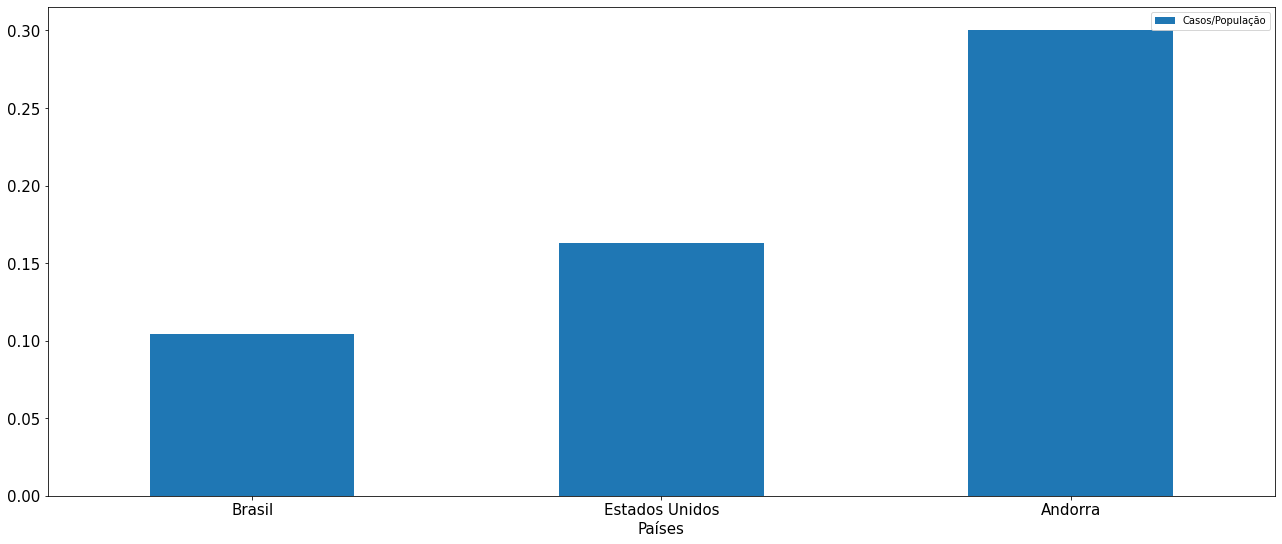

In [230]:
pd_tres_paises.plot.bar(x='nome', y='casos_por_populacao', 
                     label='Casos/População', figsize=(22,9), fontsize = 15)
plt.xlabel('Países', fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

In [231]:
df.select('iso_code', 'continent', 'location',
          'date', 'total_cases', 'total_deaths')\
          .show()

+--------+---------+-----------+-------------------+-----------+------------+
|iso_code|continent|   location|               date|total_cases|total_deaths|
+--------+---------+-----------+-------------------+-----------+------------+
|     AFG|     Asia|Afghanistan|2020-02-24 00:00:00|        5.0|        null|
|     AFG|     Asia|Afghanistan|2020-02-25 00:00:00|        5.0|        null|
|     AFG|     Asia|Afghanistan|2020-02-26 00:00:00|        5.0|        null|
|     AFG|     Asia|Afghanistan|2020-02-27 00:00:00|        5.0|        null|
|     AFG|     Asia|Afghanistan|2020-02-28 00:00:00|        5.0|        null|
|     AFG|     Asia|Afghanistan|2020-02-29 00:00:00|        5.0|        null|
|     AFG|     Asia|Afghanistan|2020-03-01 00:00:00|        5.0|        null|
|     AFG|     Asia|Afghanistan|2020-03-02 00:00:00|        5.0|        null|
|     AFG|     Asia|Afghanistan|2020-03-03 00:00:00|        5.0|        null|
|     AFG|     Asia|Afghanistan|2020-03-04 00:00:00|        5.0|

In [242]:
df.createOrReplaceTempView('covid')

In [243]:
total_mundo = spark.sql("""
SELECT 
  iso_code,
  total_cases,
  total_deaths,
  total_deaths/total_cases AS mortes_por_casos
FROM
  covid
WHERE
  date = '2021-12-31'
ORDER BY
  mortes_por_casos
    DESC
""")

total_mundo.show()

+--------+-----------+------------+--------------------+
|iso_code|total_cases|total_deaths|    mortes_por_casos|
+--------+-----------+------------+--------------------+
|     YEM|    10126.0|      1984.0| 0.19593126604779776|
|     VUT|        7.0|         1.0| 0.14285714285714285|
|     PER|  2296831.0|    202690.0| 0.08824767690787873|
|     MEX|  3979723.0|    299428.0|  0.0752384022707108|
|     SDN|    46518.0|      3331.0| 0.07160668988348597|
|     ECU|   549418.0|     33681.0| 0.06130305159277635|
|     SYR|    50278.0|      2897.0| 0.05761963483034329|
|     SOM|    23532.0|      1333.0| 0.05664626891041986|
|     EGY|   385575.0|     21752.0| 0.05641444595733645|
|     TWN|    17029.0|       850.0| 0.04991485113629691|
|     AFG|   158084.0|      7356.0|0.046532223374914604|
|     BIH|   291313.0|     13442.0|  0.0461428085941925|
|     LBR|     6278.0|       287.0| 0.04571519592226824|
|     BGR|   747108.0|     30955.0| 0.04143309936448278|
|     CHN|   115168.0|      463

In [234]:
tres_paises = total_mundo.where(f.col('iso_code').isin({'BRA','USA','PER'}))\
                                .orderBy(f.col('mortes_por_casos').asc())
tres_paises.show()

+--------+-----------+------------+--------------------+
|iso_code|total_cases|total_deaths|    mortes_por_casos|
+--------+-----------+------------+--------------------+
|     USA|5.4840479E7|    825070.0|0.015044908706942549|
|     BRA|2.2291839E7|    619334.0|0.027782992690733144|
|     PER|  2296831.0|    202690.0| 0.08824767690787873|
+--------+-----------+------------+--------------------+



In [235]:
pd_tres_paises = tres_paises.toPandas()

In [236]:
pd_tres_paises['nome'] = ['Estados Unidos', 'Brasil', 'Peru']

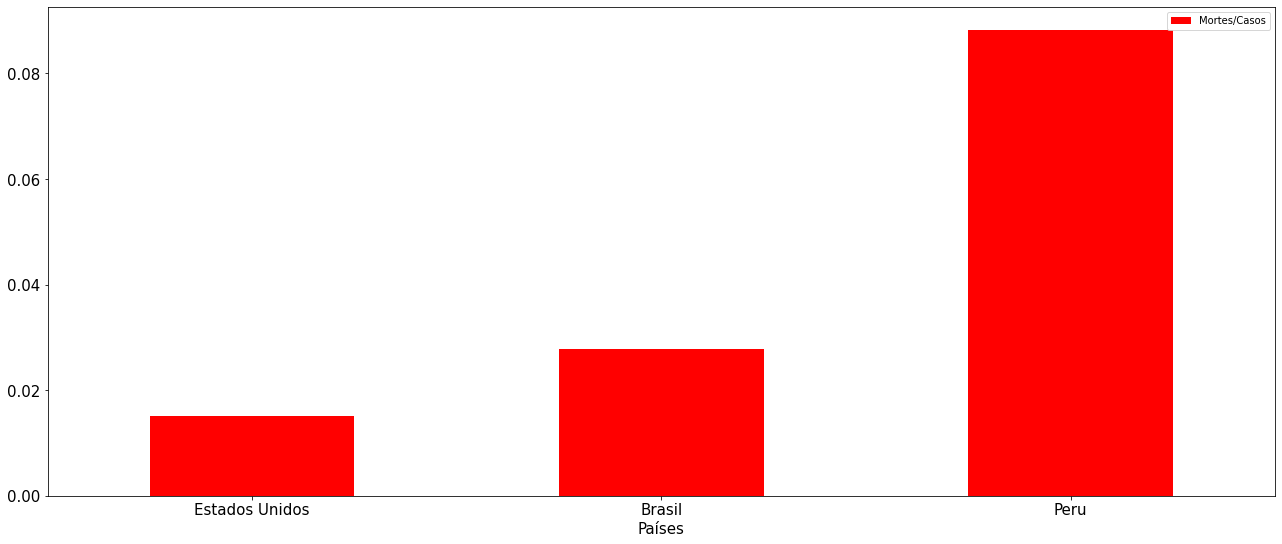

In [237]:
pd_tres_paises.plot.bar(x='nome', y='mortes_por_casos', 
                     label='Mortes/Casos', color='red', 
                     figsize=(22,9), fontsize = 15)

plt.xlabel('Países', fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

### Separando os valores referentes ao Brasil do restante do mundo

In [14]:
df_br = df.filter(f.col('iso_code') == 'BRA')
df_br.select('iso_code', 'continent', 'location', 'date', 'total_cases')\
            .orderBy('date')\
            .show()

+--------+-------------+--------+-------------------+-----------+
|iso_code|    continent|location|               date|total_cases|
+--------+-------------+--------+-------------------+-----------+
|     BRA|South America|  Brazil|2020-02-26 00:00:00|        1.0|
|     BRA|South America|  Brazil|2020-02-27 00:00:00|        1.0|
|     BRA|South America|  Brazil|2020-02-28 00:00:00|        1.0|
|     BRA|South America|  Brazil|2020-02-29 00:00:00|        2.0|
|     BRA|South America|  Brazil|2020-03-01 00:00:00|        2.0|
|     BRA|South America|  Brazil|2020-03-02 00:00:00|        2.0|
|     BRA|South America|  Brazil|2020-03-03 00:00:00|        2.0|
|     BRA|South America|  Brazil|2020-03-04 00:00:00|        4.0|
|     BRA|South America|  Brazil|2020-03-05 00:00:00|        4.0|
|     BRA|South America|  Brazil|2020-03-06 00:00:00|       13.0|
|     BRA|South America|  Brazil|2020-03-07 00:00:00|       13.0|
|     BRA|South America|  Brazil|2020-03-08 00:00:00|       20.0|
|     BRA|

### Criando uma Temp view para a manipulação com SQL

In [15]:
df_br.createOrReplaceTempView('covid_br')

### Separação do total de casos do Brasil por mês nos anos de 2020 e 2021

In [16]:
casos_br = spark.sql("""
SELECT
  distinct(date_format(date, 'MMM/yyyy')) AS Mes_Ano,
  total_cases,
  iso_code
FROM
  covid_br
WHERE
  date = last_day(date) 
    AND year(date) < 2022
    AND iso_code = 'BRA'
ORDER BY
  total_cases ASC
""")
casos_br.show()

+--------+-----------+--------+
| Mes_Ano|total_cases|iso_code|
+--------+-----------+--------+
|Feb/2020|        2.0|     BRA|
|Mar/2020|     5717.0|     BRA|
|Apr/2020|    87187.0|     BRA|
|May/2020|   516137.0|     BRA|
|Jun/2020|  1412669.0|     BRA|
|Jul/2020|  2670451.0|     BRA|
|Aug/2020|  3914829.0|     BRA|
|Sep/2020|  4817365.0|     BRA|
|Oct/2020|  5537763.0|     BRA|
|Nov/2020|  6341965.0|     BRA|
|Dec/2020|  7681032.0|     BRA|
|Jan/2021|  9208521.0|     BRA|
|Feb/2021|1.0558091E7|     BRA|
|Mar/2021|1.2763392E7|     BRA|
|Apr/2021|1.4675104E7|     BRA|
|May/2021|1.6557888E7|     BRA|
|Jun/2021|1.8570296E7|     BRA|
|Jul/2021|1.9922146E7|     BRA|
|Aug/2021|2.0785196E7|     BRA|
|Sep/2021|2.1432362E7|     BRA|
+--------+-----------+--------+
only showing top 20 rows



In [17]:
casos_br = casos_br.union(spark.createDataFrame([('Jan/2020', 0.0, 'BRA')], 
                                     casos_br.columns))\
                                     .orderBy('total_cases')
casos_br.show()

+--------+-----------+--------+
| Mes_Ano|total_cases|iso_code|
+--------+-----------+--------+
|Jan/2020|        0.0|     BRA|
|Feb/2020|        2.0|     BRA|
|Mar/2020|     5717.0|     BRA|
|Apr/2020|    87187.0|     BRA|
|May/2020|   516137.0|     BRA|
|Jun/2020|  1412669.0|     BRA|
|Jul/2020|  2670451.0|     BRA|
|Aug/2020|  3914829.0|     BRA|
|Sep/2020|  4817365.0|     BRA|
|Oct/2020|  5537763.0|     BRA|
|Nov/2020|  6341965.0|     BRA|
|Dec/2020|  7681032.0|     BRA|
|Jan/2021|  9208521.0|     BRA|
|Feb/2021|1.0558091E7|     BRA|
|Mar/2021|1.2763392E7|     BRA|
|Apr/2021|1.4675104E7|     BRA|
|May/2021|1.6557888E7|     BRA|
|Jun/2021|1.8570296E7|     BRA|
|Jul/2021|1.9922146E7|     BRA|
|Aug/2021|2.0785196E7|     BRA|
+--------+-----------+--------+
only showing top 20 rows



### Separação do total de casos do mundo por mês nos anos de 2020 e 2021

In [18]:
casos_mundo = df.groupBy(f.date_format(f.last_day(f.col('date')), 'MMM/yyyy').alias('Mes_Ano')) \
                .agg(f.sum("total_cases").alias('total_cases'))\
                .orderBy('total_cases')\
                .filter(f.substring('Mes_Ano', 5, 7) < 2022)

casos_mundo.show()

+--------+---------------+
| Mes_Ano|    total_cases|
+--------+---------------+
|Jan/2020|       154281.0|
|Feb/2020|      6673815.0|
|Mar/2020|     3.927801E7|
|Apr/2020|   2.76003419E8|
|May/2020|   6.13819381E8|
|Jun/2020|   1.02348402E9|
|Jul/2020|  1.768805163E9|
|Aug/2020|  2.739773306E9|
|Sep/2020|  3.653421595E9|
|Oct/2020|  5.048969357E9|
|Nov/2020|   6.87231132E9|
|Dec/2020|  9.610390616E9|
|Jan/2021| 1.224514442E10|
|Feb/2021|1.2845142722E10|
|Mar/2021|1.5840536997E10|
|Apr/2021|1.7709109709E10|
|May/2021|2.1194508583E10|
|Jun/2021|2.2265415617E10|
|Jul/2021|  2.46311465E10|
|Aug/2021|2.6974802578E10|
+--------+---------------+
only showing top 20 rows



### Conversão dos dataframes para pandas

In [19]:
casos_br = casos_br.toPandas()
casos_mundo = casos_mundo.toPandas()

### Normalização da coluna de casos em ambos os dataframes

In [20]:
normalizado_br = (casos_br['total_cases']-casos_br['total_cases'].min())/(casos_br['total_cases'].max()-casos_br['total_cases'].min())
casos_br['normalizado'] = normalizado_br

normalizado_mundo = (casos_mundo['total_cases']-casos_mundo['total_cases'].min())/(casos_mundo['total_cases'].max()-casos_mundo['total_cases'].min())
casos_mundo['normalizado'] = normalizado_mundo

### Gráfico apresentando a taxa de casos mensais em relação ao Brasil e ao mundo

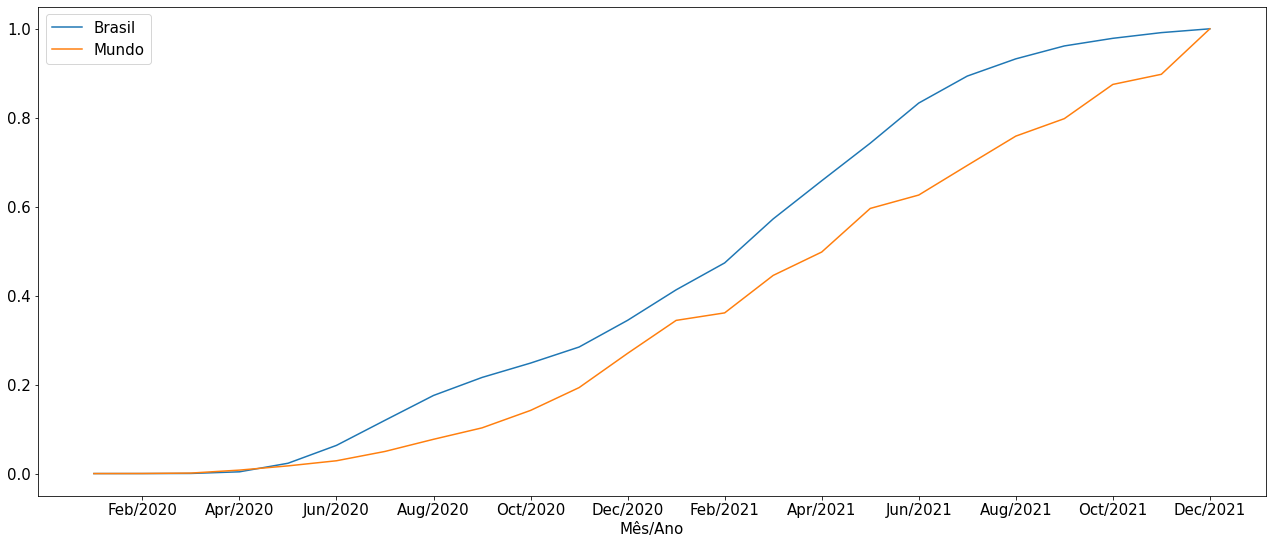

In [241]:
x_axis = casos_br['Mes_Ano'].tolist()

ax = casos_br.plot(x='Mes_Ano', y='normalizado', label='Brasil')
casos_mundo.plot(ax=ax, x='Mes_Ano', y='normalizado', label='Mundo', 
                 figsize=(22,9), fontsize = 15)

plt.xlabel('Mês/Ano', fontsize=15)
plt.legend(fontsize=15)
plt.xticks(range(1,len(x_axis),2), x_axis[1::2])
plt.show()